## LLM

In [1]:
import torch as torch
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from transformer_kristianwold.transformer import Transformer, Inference
from transformer_kristianwold.optimization import train_step, forward_and_loss, group_decay_parameters, save_checkpoint, load_checkpoint
from transformer_kristianwold.utils import saver, loader
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import matplotlib.pyplot as plt
from transformer_kristianwold.analysis import EmbeddingClustering

print("PyTorch version:", torch.__version__)  
print("CUDA toolkit version PyTorch was built with:", torch.version.cuda)  
print("cuDNN version:", torch.backends.cudnn.version()) 
print("cuda available:", torch.cuda.is_available())

device = torch.device("cpu")
torch.set_float32_matmul_precision('high')

PyTorch version: 2.7.1+cu128
CUDA toolkit version PyTorch was built with: 12.8
cuDNN version: 90701
cuda available: True


## Load

In [2]:
tokenizer = loader("../../tokenizers/cnn_tokenizer3.pkl")
model = None
def load_model(filename=None):
    embed_dim = 64*18
    ff_dim = 4*embed_dim
    heads = 18
    tf_blocks = 18

    model = Transformer(
        embed_dim=embed_dim,
        ff_dim=ff_dim,
        heads=heads,
        tf_blocks=tf_blocks,
        vocab_size=tokenizer.vocab_size,
        max_seq_len=1024,
        dropout=0.1,
        start_token_id=tokenizer.token_to_idx["<s>"],
        use_weight_tying=True
    ).to(device)

    optimizer_grouped_parameters = group_decay_parameters(
        model,
        weight_decay=0.1,
        no_decay=["bias", "LayerNorm.weight"],
        )

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5)
    scaler = torch.amp.GradScaler("cuda")
    loss_train_list = []
    loss_test_list = []

    num_epochs      = 1
    steps_per_epoch = 1
    warmup_steps    = 1000

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.0

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    if filename is not None:
        [model, 
        _, 
        _, 
        loss_train_list, 
        loss_test_list] = load_checkpoint(filename, 
                                        model, 
                                        optimizer, 
                                        scheduler, 
                                        loss_train_list, 
                                        loss_test_list)

    return model, loss_train_list, loss_test_list

## One Epoch

In [3]:
del model
model, loss_train_list, loss_test_list = load_model("../../models/checkpoint_transformer_no_regularization_1epoch.pth")

In [4]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())
print(np.median(inertia_list), np.mean(inertia_list), np.std(inertia_list))

45.09713277220726 48.00949828247229 21.1648663474281


In [5]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

    stopp
    spi
    convers
    consid
    schweinste
    mosqu
    vett
    contam
    venez
    magistr
----
   something
   somet
   whe
   odd
   wh
   too
   and
   nothing
   dig
   eight
----
   600
   900
   700
   400
   300
   450
   750
   800
   250
   350
----
    4pm
    10am
    2pm
    1pm
    11am
    7pm
    5pm
    6am
    7am
    11pm
----
   ic'
   ing'
   al'
   y'
   ies'
   ation'
   ie'
   ous'
   o'
   er'
----
    her'
    him'
    life'
    me'
    money'
    people'
    you'
    family'
    up'
    man'
----
    wawrinka
    berdych
    sharapova
    bouchard
    dimitrov
    azarenka
    wozniacki
    serena
    raonic
    djokovic
----
    july
    august
    october
    february
    december
    november
    september
    january
    june
    april
----
    we'll
    it'll
    we're
    we'd
    i'll
    you'd
    they'll
    they're
    you've
    there's
----
   26
   48
   33
   54
   46
   28
   55
   41
   36
   31
----


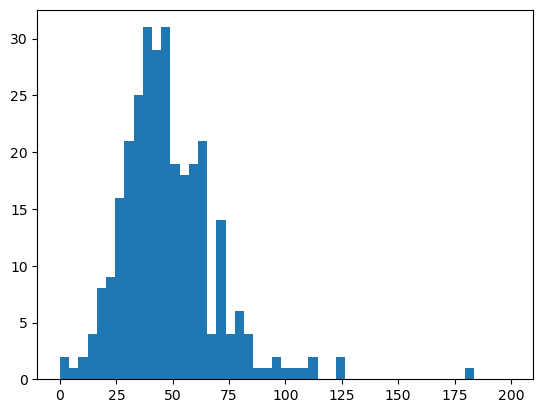

In [6]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()

## Three Epochs

In [7]:
del model
model, loss_train_list, loss_test_list = load_model("../../models/checkpoint_transformer_no_regularization_3epoch.pth")

In [8]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())
print(np.median(inertia_list), np.mean(inertia_list), np.std(inertia_list))

51.48800206184387 54.95743583649397 21.872867365748764


In [9]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

   600
   900
   400
   450
   350
   700
   750
   250
   300
   800
----
    12th
    10th
    15th
    13th
    22nd
    24th
    23rd
    14th
    16th
    17th
----
    weekend's
    saturday's
    sunday's
    sundays
    thursday's
    friday's
    week's
    saturdays
    tuesday's
    wednesday's
----
    70s
    eighties
    1940s
    sixties
    1930s
    1960s
    1950s
    1980s
    60s
    90s
----
    i
    ive
    im
    my
    we
    i'm
    i've
    i'd
    you
    id
----
    monday
    friday
    tuesday
    saturday
    thursday
    wednesday
    sunday
    afternoon
    weekend
    evening
----
    highlighting
    showcasing
    depicting
    displaying
    documenting
    exposing
    indicating
    comparing
    suggesting
    featuring
----
    insects
    ants
    spiders
    insect
    bugs
    squirrel
    rats
    bees
    rept
    rabbits
----
    teenagers
    youngsters
    youths
    toddlers
    kids
    adults
    schoolchildren
    infants
    girls

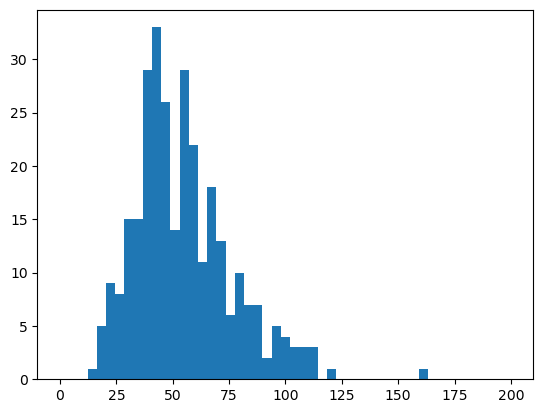

In [10]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()

## Five Epochs

In [27]:
del model
model, loss_train_list, loss_test_list = load_model("../../models/checkpoint_transformer_5epoch.pth")

In [28]:
embed_clust = EmbeddingClustering(tokenizer, n_clusters = 300)

sim_rank, inertia_rank, inertia_list = embed_clust.fit(model.get_word_embed())
print(np.median(inertia_list), np.mean(inertia_list), np.std(inertia_list))

55.00549724698067 59.44539458329479 27.803744784987757


In [29]:
for idx in inertia_rank[:10]:
    for i in range(10):
        word_idx = sim_rank[idx][i]
        print(f"   {tokenizer.idx_to_token[word_idx]}")

    print("----")

    10million
    20million
    3million
    5million
    4million
    30million
    2million
    1million
    1billion
    10m
----
    protests
    demonstrations
    demonstrators
    protesters
    protestors
    protester
    rallies
    protest
    clashes
    riots
----
    adelaide
    melbourne
    brisbane
    sydney
    queensland
    canberra
    perth
    tasman
    nsw
    sydney's
----
    70s
    eighties
    90s
    80s
    60s
    1980s
    1950s
    sixties
    1960s
    1990s
----
    22
    14
    13
    15
    23
    26
    17
    12
    25
    16
----
    2009
    2010
    2007
    2008
    2011
    2004
    2006
    2005
    2012
    november
----
   74
   73
   84
   82
   71
   69
   79
   61
   76
   83
----
    10am
    4pm
    11am
    5pm
    1am
    9am
    1pm
    2pm
    6pm
    7am
----
    12th
    10th
    15th
    23rd
    13th
    22nd
    14th
    24th
    16th
    17th
----
    shouting
    yelling
    chanting
    screaming
    sobbing
    wavin

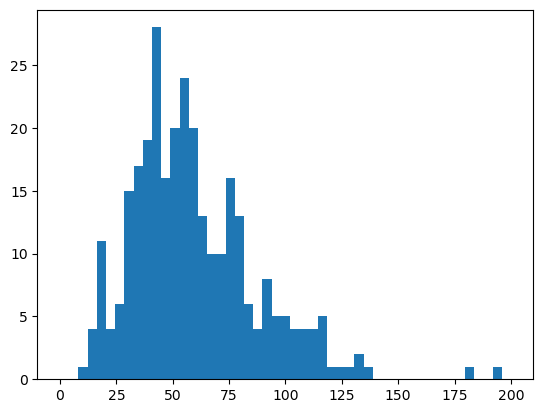

In [30]:
plt.hist(inertia_list, bins=np.linspace(0, 200, 50))
plt.show()